In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Importing and checking data

In [2]:
train_df = pd.read_csv('/kaggle/input/nlpgettingstarted/train.csv')
test_df = pd.read_csv('/kaggle/input/nlpgettingstarted/test.csv')
sample_sub_df = pd.read_csv('/kaggle/input/nlpgettingstarted/sample_submission.csv')

train_df.head() # column: 'keyword' and 'location' are a bit blank so those columns will be left out for now.
train_clean_df = train_df.drop(['keyword', 'location'], axis=1)

In [3]:
test_df.head()
test_clean_df = test_df.drop(['keyword', 'location'], axis=1)

Data cleaning process: For training data only the words should be existing in the text, no special characters (@,#,&...)

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)  # Join the words back into a string

train_clean_df['text'] = train_clean_df['text'].apply(lambda x: clean_text(x))
train_clean_df['text'] = train_clean_df['text'].apply(lambda x: remove_stopwords(x))

test_clean_df['text'] = test_clean_df['text'].apply(lambda x: clean_text(x))
test_clean_df['text'] = test_clean_df['text'].apply(lambda x: remove_stopwords(x))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
train_clean_df[train_clean_df.target == 0]

# "saving" the cleaned dataset by copying
train_df = train_clean_df.copy()
test_df = test_clean_df.copy()

train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Loading pretrained BERT model 

There are some pretrained BERT models, uncased is loaded because lower and uppercase letters are not needed to differentiate upper cased letter words and lower cased ones and large for better accuracy.

In [6]:
import transformers

from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [7]:
# converting 'text' data to tokens for BERT

print("max text lenght:",max([len(x.split()) for x in train_df.text])) # split words by space


max text lenght: 23


In [8]:
# creating input train data:
# tokenizing and creating a tensor shape input

x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=23,
    truncation=True, # if length is bigger then truncating the text
    padding=True, # every text length be the same by padding
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_train

{'input_ids': <tf.Tensor: shape=(7613, 23), dtype=int32, numpy=
array([[  101, 15616,  3114, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  3901,  2356, ...,     0,     0,     0],
       ...,
       [  101, 12779,  7359, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,   102,     0,     0],
       [  101,  6745,  5014, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7613, 23), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [9]:
x_train['input_ids'].shape

TensorShape([7613, 23])

In [10]:
# creating output train data:
y_train = train_df.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

Building a model

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [12]:
max_len = 23
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# loading the BERT model:
embeddings = bert(input_ids,attention_mask = input_mask)[1]

out = tf.keras.layers.Dropout(0.2)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 23)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 23)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 23,                                            

In [14]:
optimizer = Adam(
    learning_rate=7e-06, # base value: https://huggingface.co/bert-large-uncased
    epsilon=2e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy()
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

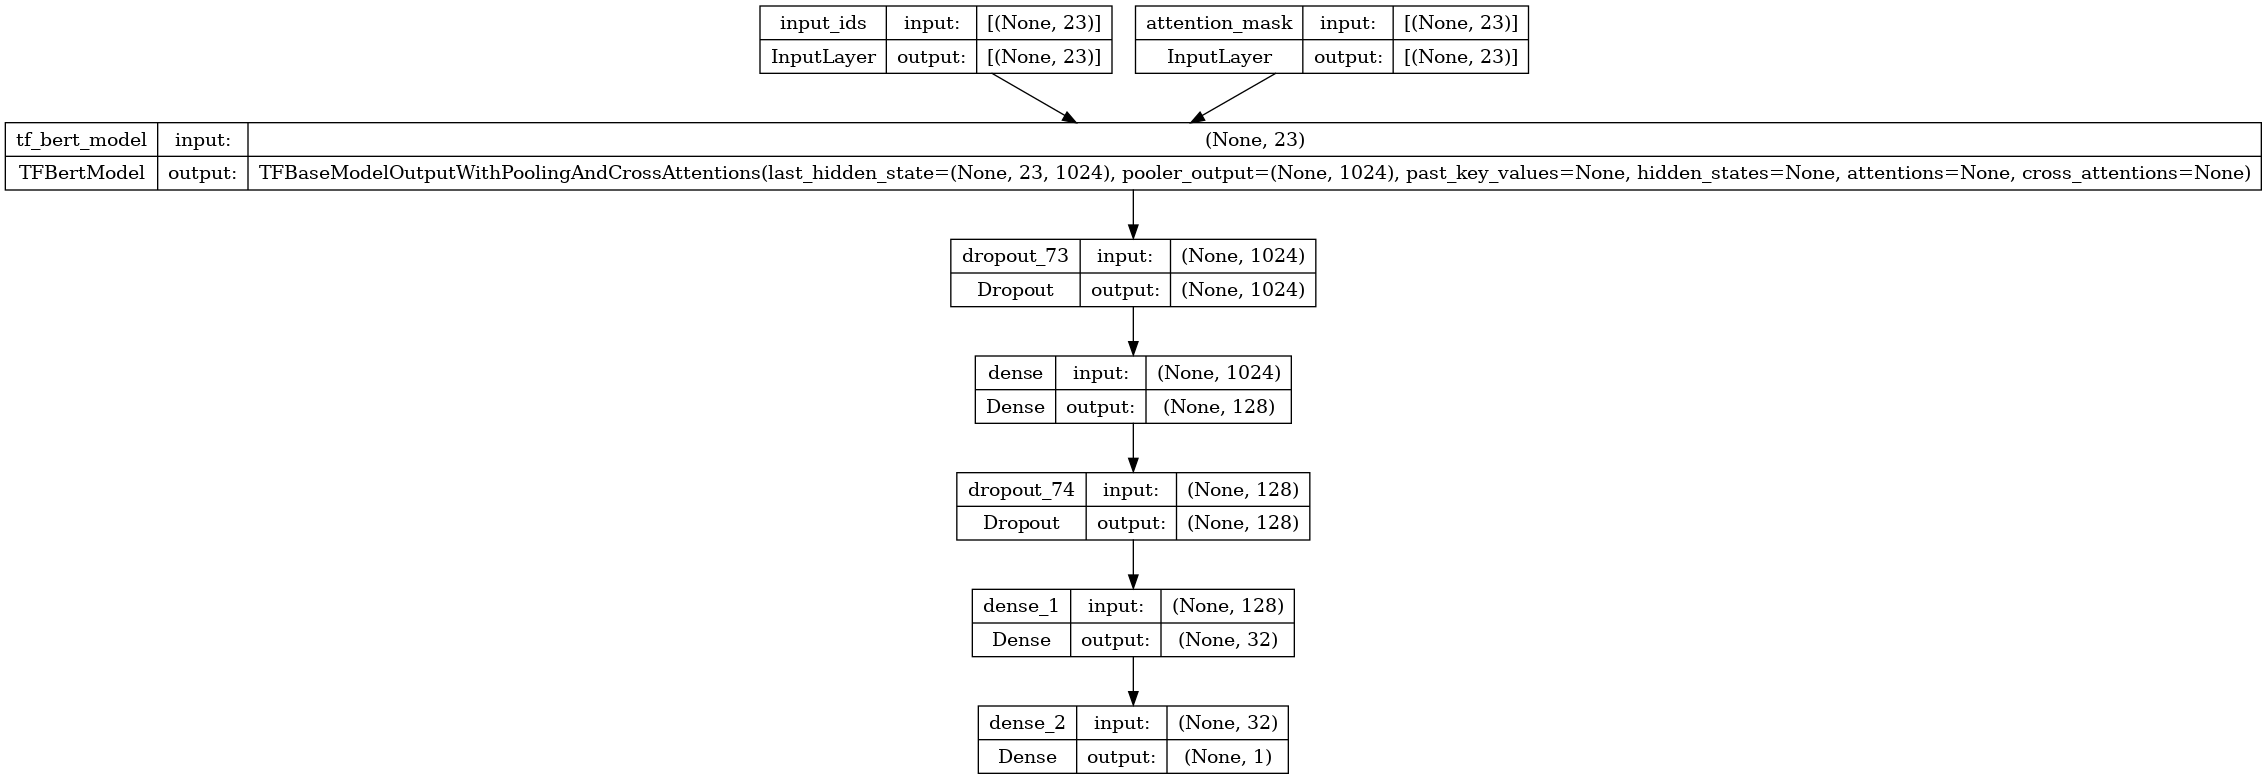

In [15]:
plot_model(model, show_shapes = True)

In [16]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

Training the model

In [17]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_split = 0.1,
    epochs=10,
    batch_size=32
)

Epoch 1/10
215/215 [==============================] - 176s 605ms/step - loss: 0.5630 - accuracy: 0.7279 - val_loss: 0.4408 - val_accuracy: 0.8084
Epoch 2/10
215/215 [==============================] - 124s 579ms/step - loss: 0.4464 - accuracy: 0.8146 - val_loss: 0.4143 - val_accuracy: 0.8215
Epoch 3/10
215/215 [==============================] - 124s 579ms/step - loss: 0.4118 - accuracy: 0.8349 - val_loss: 0.4092 - val_accuracy: 0.8255
Epoch 4/10
215/215 [==============================] - 126s 585ms/step - loss: 0.4004 - accuracy: 0.8419 - val_loss: 0.4090 - val_accuracy: 0.8268
Epoch 5/10
215/215 [==============================] - 125s 583ms/step - loss: 0.3897 - accuracy: 0.8466 - val_loss: 0.4045 - val_accuracy: 0.8307
Epoch 6/10
215/215 [==============================] - 126s 584ms/step - loss: 0.3819 - accuracy: 0.8558 - val_loss: 0.4221 - val_accuracy: 0.8281
Epoch 7/10
215/215 [==============================] - 125s 582ms/step - loss: 0.3781 - accuracy: 0.8523 - val_loss: 0.4193 -

Testing:

In [18]:
test_df

,id,text
0,0,happened terrible car crash
1,2,heard earthquake different cities stay safe ev...
2,3,forest fire spot pond geese fleeing across str...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills china taiwan
...,...,...
3258,10861,earthquake safety los angeles ûò safety faste...
3259,10865,storm ri worse last hurricane hardest hit yard...
3260,10868,green line derailment chicago
3261,10874,meg issues hazardous weather outlook hwo


In [19]:
# test input tokenizer:

x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=23,
    truncation=True, # if length is bigger then truncating the text
    padding=True, # every text length be the same by padding
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [20]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

102/102 [==============================] - 25s 182ms/step


In [21]:
y_predicted = np.where(predicted>0.5,1,0)

In [22]:
y_predicted = y_predicted.reshape((1,3263))[0]

In [23]:
sample_sub_df['id'] = test_df.id
sample_sub_df['target'] = y_predicted

In [24]:
sample_sub_df.to_csv('submission.csv',index = False)